# GPT2-Nano training


In [ ]:
import tidygrad as tg
from tidygrad import Tensor
import tidygrad.tensor
import numpy as np

import huggingface_hub

import datasets

In [ ]:
# ds = datasets.load_dataset("roneneldan/TinyStories")

In [ ]:
n_vocab = 1024
n_layers = 2
n_heads = 4
ndim = 512
ctx_len = 128

In [ ]:
def gpt2_new(n_vocab, n_layers, n_heads, ndim):
    shape_dict = {
        "wte": [n_vocab, ndim],
        "wpe": [ctx_len, ndim],
        "ln_f.weight": [ndim],
        "ln_f.bias": [ndim],
    }

    for i in range(n_layers):
        shape_dict[f"h.{i}.ln_1.weight"] = [ndim]
        shape_dict[f"h.{i}.ln_1.bias"] = [ndim]

        shape_dict[f"h.{i}.attn.c_attn.weight"] = [ndim, 3 * ndim]
        shape_dict[f"h.{i}.attn.c_attn.bias"] = [3 * ndim]

        shape_dict[f"h.{i}.attn.c_proj.weight"] = [ndim, ndim]
        shape_dict[f"h.{i}.attn.c_proj.bias"] = [ndim]

        shape_dict[f"h.{i}.ln_2.weight"] = [ndim]
        shape_dict[f"h.{i}.ln_2.bias"] = [ndim]

        shape_dict[f"h.{i}.mlp.c_fc.weight"] = [ndim, 4 * ndim]
        shape_dict[f"h.{i}.mlp.c_fc.bias"] = [4 * ndim]

        shape_dict[f"h.{i}.mlp.c_proj.weight"] = [4 * ndim, ndim]
        shape_dict[f"h.{i}.mlp.c_proj.bias"] = [ndim]

    return tg.model.Model(shape_dict)

model = gpt2_new(n_vocab=n_vocab, n_layers=n_layers, n_heads=n_heads, ndim=ndim)

t = Tensor(123, requires_grad=False)
t1 = t + t

t1.requires_grad is False
t1.parents is []

t1.requires_grad(True)

t1.requires_grad is True

But it has no parents!!!1

t1.op should be Load, not Add


In [ ]:
def gpt2_init(model):
    for k in model.params.keys():
        if k.endswith(".weight"):
            model.params[k] = Tensor(np.random.randn(*model.params[k].shape), name=k) * 0.02
        elif k.endswith(".bias"):
            model.params[k] = Tensor(np.zeros(model.params[k].shape), name=k)

    model.params["wte"] = Tensor(np.random.randn(*model.params["wte"].shape), name="wte") * 0.02
    model.params["wpe"] = Tensor(np.random.randn(*model.params["wpe"].shape), name="wpe") * 0.01

gpt2_init(model)
model.requires_grad(True)


In [ ]:
tidygrad.tensor._num_tensors

28

In [ ]:
import tidygrad.func as F

In [ ]:
def gpt2_transformer_block(model: tg.model.Model, x, n_heads, i):
    def get_params(s):
        return model.params[f"h.{i}.{s}"]

    ln_1 = F.layer_norm(x, get_params("ln_1.weight"), get_params("ln_1.bias"))

    attn_w_qkv = get_params("attn.c_attn.weight")
    attn_b_qkv = get_params("attn.c_attn.bias")

    attn_w_q, attn_w_k, attn_w_v = attn_w_qkv.split(3, axis=-1)
    attn_b_q, attn_b_k, attn_b_v = attn_b_qkv.split(3, axis=-1)

    q = ln_1.mmul(attn_w_q) + attn_b_q
    k = ln_1.mmul(attn_w_k) + attn_b_k
    v = ln_1.mmul(attn_w_v) + attn_b_v

    q_chunked = F.stack(q.split(n=n_heads, axis=-1), axis=0)
    k_chunked = F.stack(k.split(n=n_heads, axis=-1), axis=0)
    v_chunked = F.stack(v.split(n=n_heads, axis=-1), axis=0)

    dim = q_chunked.shape[-1]
    attention = q_chunked.mmul(k_chunked.transpose(-1, -2)) / np.sqrt(dim / n_heads)

    mask = np.tril(np.ones(attention.shape), k=0)
    ee = np.exp(attention) * mask

    softmaxed = ee / ee.sum(axis=-1, keepdims=True)

    attention_output = softmaxed.mmul(v_chunked)
    attention_chunks = attention_output.split(axis=0, n=n_heads)
    # print("attention_chunks", attention_chunks)

    attention_reshaped = F.concat(attention_chunks, axis=-1)
    attention_reshaped = attention_reshaped[0]
    # print("attention_reshaped", attention_reshaped)

    cproj_w = get_params("attn.c_proj.weight")
    cproj_b = get_params("attn.c_proj.bias")
    # attention_reshaped = Tensor(attention_reshaped_np)

    crosstalk = attention_reshaped.mmul(cproj_w) + cproj_b

    after_residual = crosstalk + x
    # print("after_residual", after_residual)
    ln2_w = get_params("ln_2.weight")
    ln2_b = get_params("ln_2.bias")

    after_ln2 = F.layer_norm(after_residual, ln2_w, ln2_b)

    mlp_c_fc_w = get_params("mlp.c_fc.weight")
    mlp_c_fc_b = get_params("mlp.c_fc.bias")

    after_up = after_ln2.mmul(mlp_c_fc_w) + mlp_c_fc_b
    # print("after_up", after_up)

    after_up_a = F.gelu(after_up)
    # print("after_up_a", after_up_a)

    mlp_c_proj_w = get_params("mlp.c_proj.weight")
    mlp_c_proj_b = get_params("mlp.c_proj.bias")

    after_down = after_up_a.mmul(mlp_c_proj_w) + mlp_c_proj_b

    output = after_down + after_residual
    return output

def gpt2(model, input, n_layers, n_heads):
    def get_params(s):
        return model.params[s]

    token_embeddings = F.embedding(get_params("wte"), input)
    position_embeddings = F.embedding(get_params("wpe"), np.arange(input.shape[-1]))

    x = token_embeddings + position_embeddings

    # print("first embedding", x)

    for i in range(n_layers):
        print("layer", i)
        x = gpt2_transformer_block(model=model, x=x, n_heads=n_heads, i=i)

    return F.layer_norm(x, w=get_params("ln_f.weight"), b=get_params("ln_f.bias"))


In [ ]:
# res = gpt2(model, np.arange(256).reshape(2, -1), n_layers=n_layers, n_heads=n_heads)
# res.sum().backward()

In [ ]:
# from tidygrad.training import one_hot_encode_batch

In [ ]:
def one_hot_encode(batch, n_classes):
    batch_size, sequence_length = batch.shape
    one_hot = np.zeros((batch_size, sequence_length, n_classes))
    rows, cols = np.indices((batch_size, sequence_length))
    one_hot[rows, cols, batch] = 1
    return one_hot

In [ ]:
def language_modeling_loss(model, input, target, n_layers, n_heads):
    res = gpt2(model, input, n_layers, n_heads)
    # print("res", res)
    # print("wte", model.params["wte"])
    logits = res.mmul(model.params["wte"].transpose(-1, -2), name="logits")

    # print("logits", logits)
    loss = F.CrossEntropy_loss(logits, one_hot_encode(target, n_classes=n_vocab))
    return loss

# loss = language_modeling_loss(
#     model, input=np.random.randint(0, n_vocab, size=(2, ctx_len)), target=np.random.randint(0, n_vocab, size=(2, ctx_len)), n_layers=n_layers, n_heads=n_heads
# )

# print("loss", loss)

In [ ]:
# np.seterr(all="raise")
# l = loss.sum()
# print(loss)

# l.backward()

In [ ]:
# with open("datasets/TinyStories/TinyStories.txt", "r") as file:
#     tokens = file.read()


In [ ]:
# Dataset:

# dataset = ["Lilly gsdsgfsdfsd sf sfds"] <- You can no sample from ths

# dataset = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15.....]

# ctx len = 5

# dataset[0] = [1,2,3,4,5]
# dataset[1] = [2,3,4,5,6]
# dataset[2] = [3,4,5,6,7]
# dataset[3] = [4,5,6,7,8]

from tidygrad.utils.datasets import Dataset, DataLoader

tokens = np.load("./datasets/TinyStories/TinyStories_1percent_ids.npy")

class TSDataset(Dataset):
    def __init__(self, token_array, ctx_len):
        self.token_array = token_array
        self.ctx_len = ctx_len

    def __len__(self):
        return len(self.token_array) - self.ctx_len - 1

    def __getitem__(self, i):
        return self.token_array[i:i + self.ctx_len], self.token_array[i + 1:i + self.ctx_len + 1]

    def collate_fn(self, batch):
        # print("batch", batch) # [(x1, y1), (x2, y2), (x3, y3)]
        return np.stack([x for x, y in batch]), np.stack([y for x, y in batch])

dataset = TSDataset(tokens, 2)


In [ ]:
import math

In [ ]:
class TSDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, batch_tfms=None, ctx_len=128, fake_epoch_len=50, seed=1337):
        super().__init__(dataset=dataset, batch_size=batch_size, batch_tfms=batch_tfms)
        self.fake_epoch_len = fake_epoch_len
        self.ctx_len = ctx_len
        self.rng = np.random.default_rng(seed)

    def __len__(self):
        return min((len(self.dataset) // self.batch_size) // self.ctx_len, self.fake_epoch_len)

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= min(len(self), self.fake_epoch_len):
            raise StopIteration

        idxs = self.rng.integers(0, len(self.dataset), size=(self.batch_size, ))

        batch = [self.dataset[i] for i in idxs]
        batch = self.dataset.collate_fn(batch)

        self.i += 1

        return batch

dataloader = TSDataLoader(dataset, batch_size=64)


In [ ]:
from tidygrad.utils.data import DataLoaders

In [ ]:
X, y = next(iter(dataloader))

print("X", X.shape)
print("y", y.shape)

X (64, 2)
y (64, 2)


In [ ]:
from tidygrad.training import Learner

from tidygrad.optim import Adam
from functools import partial

In [ ]:
import tidygrad.tensor


In [ ]:
def loss_function(X, y):
    # y = Tensor(y)
    logits = X.mmul(model.params["wte"].transpose(-1, -2), name="logits")

    # print("X", X)
    # print("y", y)
    # print("logits", logits)

    one_one_hot = one_hot_encode(y, n_vocab)

    loss = F.CrossEntropy_loss(logits, one_one_hot, reduction="sum")

    print("loss", loss)
    loss = loss.mean()

    print("post_epoch num tensors", tidygrad.tensor._num_tensors)

    return loss

In [ ]:
from tidygrad.training import DictLoggerCallback, ProgressBarCallback, Loss

In [ ]:
class OneBatchCallback:
    def __init__(self):
        self.i = 0

    def post_loss(self, learner):
        print("post_batch_backward", self.i)
        if self.i == 1:
            raise Exception("post_batch_backward")
        self.i += 1

class MemleakCallback:
    def __init__(self):
        self.i = 0
        print("init")

    def post_epoch(self, learner):
        print("post_epoch num tensors", tidygrad.tensor._num_tensors)


In [ ]:
model_funct = partial(gpt2, n_layers=n_layers, n_heads=n_heads)

def model_funct(input):
    return gpt2(model, input, n_layers=n_layers, n_heads=n_heads)

optim = Adam(lr=0.001, params=model.parameter_list())

ler = Learner(
    model=model_funct,
    dataloaders=DataLoaders(train=dataloader, test=dataloader),
    loss_func=loss_function,
    optimizer=optim,
    callbacks=[DictLoggerCallback(metrics=[Loss()]),
               ProgressBarCallback(metrics=[
                   "loss", 
               ], plot_train_skip_ylim=15, plot_smooth_training=5),
               MemleakCallback()],
)

init


In [ ]:
len(dataloader)

50

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

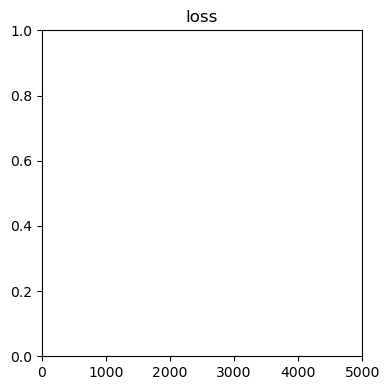

layer 0
layer 1
loss Tensor[64, 2, 1](name="" op=Sum parents=[]):
    v=array[64, 2, 1] f32 n=128 x∈[6.908, 6.953] μ=6.931 σ=0.009
    ∇=array[64, 2, 1] f32 n=128 all_zeros
post_epoch num tensors 325
layer 0
layer 1
loss Tensor[64, 2, 1](name="" op=Sum parents=[]):
    v=array[64, 2, 1] f32 n=128 x∈[6.859, 6.951] μ=6.925 σ=0.016
    ∇=array[64, 2, 1] f32 n=128 all_zeros
post_epoch num tensors 325
layer 0
layer 1
loss Tensor[64, 2, 1](name="" op=Sum parents=[]):
    v=array[64, 2, 1] f32 n=128 x∈[6.842, 6.959] μ=6.913 σ=0.029
    ∇=array[64, 2, 1] f32 n=128 all_zeros
post_epoch num tensors 325


/home/xl0/work/projects/grads/tidygrad/tidygrad/ops/common.py:190: RuntimeWarning: underflow encountered in multiply
  self.parents[1].accum_grad(self.out.grad * self.parents[0].data)


layer 0
layer 1
loss Tensor[64, 2, 1](name="" op=Sum parents=[]):
    v=array[64, 2, 1] f32 n=128 x∈[6.792, 6.958] μ=6.903 σ=0.036
    ∇=array[64, 2, 1] f32 n=128 all_zeros
post_epoch num tensors 325
layer 0
layer 1
loss Tensor[64, 2, 1](name="" op=Sum parents=[]):
    v=array[64, 2, 1] f32 n=128 x∈[6.778, 6.972] μ=6.898 σ=0.048
    ∇=array[64, 2, 1] f32 n=128 all_zeros
post_epoch num tensors 325
layer 0
layer 1
loss Tensor[64, 2, 1](name="" op=Sum parents=[]):
    v=array[64, 2, 1] f32 n=128 x∈[6.732, 7.001] μ=6.886 σ=0.058
    ∇=array[64, 2, 1] f32 n=128 all_zeros
post_epoch num tensors 325
layer 0
layer 1
loss Tensor[64, 2, 1](name="" op=Sum parents=[]):
    v=array[64, 2, 1] f32 n=128 x∈[6.722, 6.983] μ=6.874 σ=0.065
    ∇=array[64, 2, 1] f32 n=128 all_zeros
post_epoch num tensors 325
layer 0
layer 1
loss Tensor[64, 2, 1](name="" op=Sum parents=[]):
    v=array[64, 2, 1] f32 n=128 x∈[6.690, 6.980] μ=6.876 σ=0.072
    ∇=array[64, 2, 1] f32 n=128 all_zeros
post_epoch num tensors 325


In [ ]:
ler.fit(epochs=100)

In [ ]:
print(tidygrad.tensor._num_tensors)

import gc
gc.collect()

print(tidygrad.tensor._num_tensors)



69
69
